In [29]:
import time
import os

import scanpy
import numpy as np
import scipy.sparse as sp

import torch
from torch import optim
from torch.utils.data import DataLoader

import models.loadImg as loadImg
import models.modelsCNN as modelsCNN
import models.optimizer as optimizer

import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import gc
from skimage import io
import umap
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans

In [2]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "1" 
os.environ["CUDA_VISIBLE_DEVICES"] = "2" 

In [3]:
radius=48
datadir='/media/xinyi/dcis2idc1/data'
sampleList=[]
for s in os.listdir('/media/xinyi/dcis2idc1/data'):
    if 'hoechst'  in s and ('_1_' in s or '_3_' in s or '_4_' in s or '_6_' in s):
#     if 'hoechst'  in s and ('_3_' in s or '_4_' in s or '_6_' in s):
        sampleList.append(s)
print(sampleList)
trainingCores={'br1003a':[],'br8018a':[],'br301':[]}
for s in range(1,11):
# for s in range(5,11):
    trainingCores['br1003a'].append('A'+str(s))
    trainingCores['br1003a'].append('C'+str(s))
    trainingCores['br1003a'].append('I'+str(s))
for s in range(1,11):
    if s<9:
        trainingCores['br8018a'].append('H'+str(s))
    trainingCores['br8018a'].append('A'+str(s))
    trainingCores['br8018a'].append('B'+str(s))
    trainingCores['br8018a'].append('F'+str(s))
for s in range(1,7):
    for sr in ['A','B','C','D','E']:
        trainingCores['br301'].append(sr+str(s))

['br1003a_1_cytokeratin_555_aSMA_647_hoechst', 'br1003a_3_collagen1_647_hoechst', 'br1003a_4_cytokeratin_555_gh2ax_647_hoechst', 'br301_4_cytokeratin_555_aSMA_647_hoechst', 'br301_6_collagen1_647_hoechst', 'br8018a_1_cytokeratin_555_aSMA_647_hoechst', 'br8018a_3_collagen1_647_hoechst', 'br8018a_4_cytokeratin_555_gh2ax_647_hoechst']


In [4]:
trainingCores

{'br1003a': ['A1',
  'C1',
  'I1',
  'A2',
  'C2',
  'I2',
  'A3',
  'C3',
  'I3',
  'A4',
  'C4',
  'I4',
  'A5',
  'C5',
  'I5',
  'A6',
  'C6',
  'I6',
  'A7',
  'C7',
  'I7',
  'A8',
  'C8',
  'I8',
  'A9',
  'C9',
  'I9',
  'A10',
  'C10',
  'I10'],
 'br8018a': ['H1',
  'A1',
  'B1',
  'F1',
  'H2',
  'A2',
  'B2',
  'F2',
  'H3',
  'A3',
  'B3',
  'F3',
  'H4',
  'A4',
  'B4',
  'F4',
  'H5',
  'A5',
  'B5',
  'F5',
  'H6',
  'A6',
  'B6',
  'F6',
  'H7',
  'A7',
  'B7',
  'F7',
  'H8',
  'A8',
  'B8',
  'F8',
  'A9',
  'B9',
  'F9',
  'A10',
  'B10',
  'F10'],
 'br301': ['A1',
  'B1',
  'C1',
  'D1',
  'E1',
  'A2',
  'B2',
  'C2',
  'D2',
  'E2',
  'A3',
  'B3',
  'C3',
  'D3',
  'E3',
  'A4',
  'B4',
  'C4',
  'D4',
  'E4',
  'A5',
  'B5',
  'C5',
  'D5',
  'E5',
  'A6',
  'B6',
  'C6',
  'D6',
  'E6']}

In [3]:
allImg=loadImg.loadImg(datadir,sampleList,trainingCores,'segmented_nucleus','zproject/dna',radius,minmax=True)

['br1003a_1_cytokeratin_555_aSMA_647_hoechst', 'br1003a_3_collagen1_647_hoechst', 'br1003a_4_cytokeratin_555_gh2ax_647_hoechst', 'br301_4_cytokeratin_555_aSMA_647_hoechst', 'br301_6_collagen1_647_hoechst', 'br8018a_1_cytokeratin_555_aSMA_647_hoechst', 'br8018a_3_collagen1_647_hoechst', 'br8018a_4_cytokeratin_555_gh2ax_647_hoechst']
br1003a_1_cytokeratin_555_aSMA_647_hoechst
A1
C1
I1
A2
C2
I2
C3
I3
A4
C4
A5
C5
A6
C6
A7
C7
I7
A8
C8
I8
A9
C9
I9
C10
I10
br1003a_3_collagen1_647_hoechst
A1
C1
I1
A2
C2
I2
A3
C3
I3
C4
A5
C5
A6
C6
A7
C7
I7
A8
C8
I8
A9
C9
I9
C10
I10
br1003a_4_cytokeratin_555_gh2ax_647_hoechst
A1
C1
I1
A2
C2
I2
A3
I3
A4
C4
A5
C5
A6
C6
A7
C7
I7
A8
C8
I8
A9
C9
I9
A10
C10
br301_4_cytokeratin_555_aSMA_647_hoechst
A1
B1
C1
D1
E1
A2
B2
C2
D2
E2
A3
B3
C3
D3
E3
A4
B4
C4
D4
E4
A5
B5
C5
D5
E5
A6
B6
C6
D6
E6
br301_6_collagen1_647_hoechst
A1
B1
C1
D1
E1
A2
B2
C2
D2
E2
A3
B3
C3
D3
E3
A4
B4
C4
D4
E4
A5
B5
C5
D5
E5
A6
B6
C6
D6
E6
br8018a_1_cytokeratin_555_aSMA_647_hoechst
H1
A1
B1
F1
H2
A2
B2
F

In [18]:
sampleList_add=['br8018a_4_cytokeratin_555_gh2ax_647_hoechst']
trainingCores_add={'br8018a':['H2','H4','H7']}

In [8]:
addImg=loadImg.loadImg(datadir,sampleList_add,trainingCores_add,'segmented_nucleus','zproject/dna',radius,minmax=True)

br8018a_4_cytokeratin_555_gh2ax_647_hoechst
H2
H4
H7


In [9]:
allImg=np.concatenate((allImg,addImg),axis=0)

In [10]:
allImg.shape

(1876734, 1, 96, 96)

In [11]:
with open(os.path.join(datadir,'processed','train_cnnvae'), 'wb') as output:
    pickle.dump(allImg, output, pickle.HIGHEST_PROTOCOL)

In [12]:
#train-test split
np.random.seed(3)
pctVal=0.05
pctTest=0.1
allIdx=np.arange(allImg.shape[0])
np.random.shuffle(allIdx)
valIdx=allIdx[:int(pctVal*allImg.shape[0])]
testIdx=allIdx[int(pctVal*allImg.shape[0]):(int(pctVal*allImg.shape[0])+int(pctTest*allImg.shape[0]))]
trainIdx=allIdx[(int(pctVal*allImg.shape[0])+int(pctTest*allImg.shape[0])):]

In [13]:
with open(os.path.join(datadir,'processed','train_cnnvae_trainIdx'), 'wb') as output:
    pickle.dump(trainIdx, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(datadir,'processed','train_cnnvae_valIdx'), 'wb') as output:
    pickle.dump(valIdx, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(datadir,'processed','train_cnnvae_testIdx'), 'wb') as output:
    pickle.dump(testIdx, output, pickle.HIGHEST_PROTOCOL)

In [4]:
with open(os.path.join(datadir,'processed','train_cnnvae'), 'rb') as input:
    allImg=pickle.load(input)
with open(os.path.join(datadir,'processed','train_cnnvae_trainIdx'), 'rb') as input:
    trainIdx=pickle.load(input)
with open(os.path.join(datadir,'processed','train_cnnvae_valIdx'), 'rb') as input:
    valIdx=pickle.load(input)
with open(os.path.join(datadir,'processed','train_cnnvae_testIdx'), 'rb') as input:
    testIdx=pickle.load(input)

In [5]:
#VAE settings
seed=3
epochs=10000
saveFreq=2000
lr=0.00001 #initial learning rate
lr_adv=0.001
weight_decay=0 #Weight for L2 loss on embedding matrix.

# batchsize=4
batchsize=4000
kernel_size=4
stride=2
padding=1

# fc_dim1=6000
hidden1=64 #Number of channels in hidden layer 1
hidden2=128 
hidden3=256
fc_dim1=256*12*12
fc_dim2=50
# fc_dim3=128
# fc_dim4=128
# gcn_dim1=2600
# adv_hidden=128

dropout=0.01
kl_weight=0.0000001
model_str='cnn_vae_lessLayers'

name='exp2_lessLayers'
logsavepath='/media/xinyi/dcis2idc1/log/cnnvae'+name
modelsavepath='/media/xinyi/dcis2idc1/models/cnnvae'+name
plotsavepath='/media/xinyi/dcis2idc1/plots/cnnvae'+name


if not os.path.exists(logsavepath):
    os.mkdir(logsavepath)
if not os.path.exists(modelsavepath):
    os.mkdir(modelsavepath)
if not os.path.exists(plotsavepath):
    os.mkdir(plotsavepath)

In [6]:
# Set cuda and seed
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.enabled = True
    
loss_match=torch.nn.MSELoss()
# Create model
if model_str=='cnn_vae':
    modelcnn = modelsCNN.CNN_VAE(kernel_size, stride, padding, 1, hidden1, hidden2, hidden3, hidden4, hidden5, fc_dim1,fc_dim2)
    loss_kl=optimizer.optimizer_kl
    loss_x=torch.nn.MSELoss()
if model_str=='cnn_vae_lessLayers':
    modelcnn = modelsCNN.CNN_VAE_small(kernel_size, stride, padding, 1, hidden1, hidden2, hidden3, fc_dim1,fc_dim2)
    loss_kl=optimizer.optimizer_kl
    loss_x=torch.nn.MSELoss()
if model_str=='cnn_vae_sharded':
    modelcnn = modelsCNN.CNN_VAE_sharded(kernel_size, stride, padding, 1, hidden1, hidden2, hidden3, hidden4, hidden5, fc_dim1,fc_dim2)
    loss_kl=optimizer.optimizer_kl
    loss_x=torch.nn.MSELoss()
    use_cuda=False

if model_str=='cnn_vae_alexnet':
    modelcnn = modelsCNN.CNN_VAE_alexnet(fc_dim1)
    loss_kl=optimizer.optimizer_kl
    loss_x=torch.nn.MSELoss(reduction='sum')

    
modelcnn.cuda()       
optimizerCNN = optim.Adam(modelcnn.parameters(), lr=lr, weight_decay=weight_decay)

In [7]:
use_cuda=True
def train(epoch):
    t = time.time()
    modelcnn.train()
    
    loss_kl_train_all=0
    loss_x_train_all=0
    loss_all=0
    ntrainBatches=int(np.ceil(trainIdx.shape[0]/batchsize))
    for i in range(ntrainBatches):
#         if i%200==0:
#         print(i)
        trainIdx_i=trainIdx[i*batchsize:min((i+1)*batchsize,trainIdx.shape[0])]
        trainInput=torch.tensor(allImg[trainIdx_i])
#         print(trainInput.shape)

        if use_cuda:
            trainInput=trainInput.cuda().float()
        optimizerCNN.zero_grad()

        recon, z, mu, logvar = modelcnn(trainInput)

        loss_kl_train=loss_kl(mu, logvar)
        loss_x_train=loss_x(recon, trainInput)
        loss=loss_kl_train*kl_weight+loss_x_train
        
        
        loss_kl_train_all+=loss_kl_train.item()
        loss_x_train_all+=loss_x_train.item()
        loss_all+=loss.item()
        
        loss.backward()
        optimizerCNN.step()

    loss_kl_train_all=loss_kl_train_all/ntrainBatches
    loss_x_train_all=loss_x_train_all/ntrainBatches
    loss_all=loss_all/ntrainBatches
    
    with torch.no_grad():
        modelcnn.eval()
        loss_val_all=0
        nvalBatches=int(np.ceil(valIdx.shape[0]/batchsize))
        for i in range(nvalBatches):
            valIdx_i=valIdx[i*batchsize:min((i+1)*batchsize,valIdx.shape[0])]
            valInput=torch.tensor(allImg[valIdx_i])
            if use_cuda:
                valInput=valInput.cuda().float()
            recon,z, mu, logvar = modelcnn(valInput)

            loss_val=loss_x(recon, valInput).item()

            loss_val_all+=loss_val

        loss_val_all=loss_val_all/nvalBatches
    
    print('Epoch: {:04d}'.format(epoch),
          'loss_train: {:.4f}'.format(loss_all),
          'loss_kl_train: {:.4f}'.format(loss_kl_train_all),
          'loss_x_train: {:.4f}'.format(loss_x_train_all),
          'loss_val: {:.4f}'.format(loss_val_all),
          'time: {:.4f}s'.format(time.time() - t))
    return loss_all,loss_kl_train_all,loss_x_train_all,loss_val_all

    
train_loss_ep=[None]*epochs
train_loss_kl_ep=[None]*epochs
train_loss_x_ep=[None]*epochs
val_loss_ep=[None]*epochs
t_ep=time.time()

# pre_t=4
pre_t=-1
for ep in range(epochs):
# for ep in range(10000,20000):
    train_loss_ep[ep],train_loss_kl_ep[ep],train_loss_x_ep[ep],val_loss_ep[ep]=train(ep)

        
    if ep%saveFreq == (saveFreq-1):
        torch.save(modelcnn.cpu().state_dict(), os.path.join(modelsavepath,str(ep)+'.pt'))
    if use_cuda:
        modelcnn.cuda()
        torch.cuda.empty_cache()
print(' total time: {:.4f}s'.format(time.time() - t_ep))

Epoch: 0000 loss_train: 0.1501 loss_kl_train: 538.4607 loss_x_train: 0.1500 loss_val: 0.0614 time: 265.9317s
Epoch: 0001 loss_train: 0.0461 loss_kl_train: 0.0832 loss_x_train: 0.0461 loss_val: 0.0288 time: 257.2746s
Epoch: 0002 loss_train: 0.0253 loss_kl_train: 0.0686 loss_x_train: 0.0253 loss_val: 0.0216 time: 257.3351s
Epoch: 0003 loss_train: 0.0193 loss_kl_train: 0.0718 loss_x_train: 0.0193 loss_val: 0.0173 time: 257.2062s
Epoch: 0004 loss_train: 0.0158 loss_kl_train: 0.0757 loss_x_train: 0.0158 loss_val: 0.0146 time: 257.0840s
Epoch: 0005 loss_train: 0.0136 loss_kl_train: 0.0790 loss_x_train: 0.0136 loss_val: 0.0127 time: 257.2181s
Epoch: 0006 loss_train: 0.0119 loss_kl_train: 0.0824 loss_x_train: 0.0119 loss_val: 0.0113 time: 257.2037s
Epoch: 0007 loss_train: 0.0106 loss_kl_train: 0.0859 loss_x_train: 0.0106 loss_val: 0.0099 time: 257.1730s
Epoch: 0008 loss_train: 0.0092 loss_kl_train: 0.0900 loss_x_train: 0.0092 loss_val: 0.0085 time: 257.0979s
Epoch: 0009 loss_train: 0.0078 loss

Epoch: 0078 loss_train: 0.0009 loss_kl_train: 0.2053 loss_x_train: 0.0009 loss_val: 0.0009 time: 254.1694s
Epoch: 0079 loss_train: 0.0009 loss_kl_train: 0.2059 loss_x_train: 0.0009 loss_val: 0.0009 time: 254.2793s
Epoch: 0080 loss_train: 0.0009 loss_kl_train: 0.2064 loss_x_train: 0.0009 loss_val: 0.0009 time: 254.2935s
Epoch: 0081 loss_train: 0.0009 loss_kl_train: 0.2068 loss_x_train: 0.0009 loss_val: 0.0009 time: 254.1010s
Epoch: 0082 loss_train: 0.0009 loss_kl_train: 0.2073 loss_x_train: 0.0009 loss_val: 0.0009 time: 254.1257s
Epoch: 0083 loss_train: 0.0009 loss_kl_train: 0.2081 loss_x_train: 0.0009 loss_val: 0.0009 time: 254.2542s
Epoch: 0084 loss_train: 0.0009 loss_kl_train: 0.2084 loss_x_train: 0.0009 loss_val: 0.0009 time: 254.2995s
Epoch: 0085 loss_train: 0.0009 loss_kl_train: 0.2091 loss_x_train: 0.0009 loss_val: 0.0009 time: 254.3083s
Epoch: 0086 loss_train: 0.0009 loss_kl_train: 0.2097 loss_x_train: 0.0009 loss_val: 0.0009 time: 254.2154s
Epoch: 0087 loss_train: 0.0009 loss_k

Epoch: 0155 loss_train: 0.0006 loss_kl_train: 0.2522 loss_x_train: 0.0006 loss_val: 0.0006 time: 254.0507s
Epoch: 0156 loss_train: 0.0006 loss_kl_train: 0.2527 loss_x_train: 0.0006 loss_val: 0.0006 time: 253.7903s
Epoch: 0157 loss_train: 0.0006 loss_kl_train: 0.2533 loss_x_train: 0.0006 loss_val: 0.0006 time: 254.1094s
Epoch: 0158 loss_train: 0.0006 loss_kl_train: 0.2538 loss_x_train: 0.0006 loss_val: 0.0006 time: 254.1077s
Epoch: 0159 loss_train: 0.0006 loss_kl_train: 0.2544 loss_x_train: 0.0006 loss_val: 0.0006 time: 253.9784s
Epoch: 0160 loss_train: 0.0006 loss_kl_train: 0.2550 loss_x_train: 0.0006 loss_val: 0.0006 time: 254.1837s
Epoch: 0161 loss_train: 0.0006 loss_kl_train: 0.2556 loss_x_train: 0.0006 loss_val: 0.0006 time: 254.2853s
Epoch: 0162 loss_train: 0.0006 loss_kl_train: 0.2563 loss_x_train: 0.0006 loss_val: 0.0006 time: 254.2421s
Epoch: 0163 loss_train: 0.0006 loss_kl_train: 0.2570 loss_x_train: 0.0006 loss_val: 0.0006 time: 253.8632s
Epoch: 0164 loss_train: 0.0006 loss_k

Epoch: 0232 loss_train: 0.0006 loss_kl_train: 0.2980 loss_x_train: 0.0006 loss_val: 0.0006 time: 254.1855s
Epoch: 0233 loss_train: 0.0006 loss_kl_train: 0.2985 loss_x_train: 0.0006 loss_val: 0.0006 time: 254.1240s
Epoch: 0234 loss_train: 0.0006 loss_kl_train: 0.2990 loss_x_train: 0.0006 loss_val: 0.0006 time: 254.2102s
Epoch: 0235 loss_train: 0.0006 loss_kl_train: 0.2995 loss_x_train: 0.0006 loss_val: 0.0006 time: 254.4031s
Epoch: 0236 loss_train: 0.0006 loss_kl_train: 0.3000 loss_x_train: 0.0006 loss_val: 0.0006 time: 254.2520s
Epoch: 0237 loss_train: 0.0006 loss_kl_train: 0.3007 loss_x_train: 0.0006 loss_val: 0.0006 time: 254.0833s
Epoch: 0238 loss_train: 0.0006 loss_kl_train: 0.3012 loss_x_train: 0.0006 loss_val: 0.0006 time: 254.1893s
Epoch: 0239 loss_train: 0.0006 loss_kl_train: 0.3018 loss_x_train: 0.0006 loss_val: 0.0006 time: 253.9181s
Epoch: 0240 loss_train: 0.0006 loss_kl_train: 0.3022 loss_x_train: 0.0006 loss_val: 0.0006 time: 253.9162s
Epoch: 0241 loss_train: 0.0006 loss_k

Epoch: 0309 loss_train: 0.0005 loss_kl_train: 0.3388 loss_x_train: 0.0005 loss_val: 0.0005 time: 257.6332s
Epoch: 0310 loss_train: 0.0005 loss_kl_train: 0.3393 loss_x_train: 0.0005 loss_val: 0.0005 time: 257.5696s


KeyboardInterrupt: 

In [8]:
torch.save(modelcnn.cpu().state_dict(), os.path.join(modelsavepath,str(ep)+'.pt'))

In [9]:
with open(os.path.join(logsavepath,'train_loss'), 'wb') as output:
    pickle.dump(train_loss_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'train_loss_kl'), 'wb') as output:
    pickle.dump(train_loss_kl_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'train_loss_x'), 'wb') as output:
    pickle.dump(train_loss_x_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'val_loss'), 'wb') as output:
    pickle.dump(val_loss_ep, output, pickle.HIGHEST_PROTOCOL)


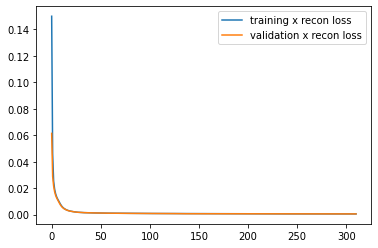

In [10]:
plt.plot(np.arange(epochs),train_loss_x_ep)
plt.plot(np.arange(epochs),val_loss_ep)
# plt.plot(np.arange(epochs),train_loss_kl_ep)
plt.legend(['training x recon loss','validation x recon loss','training kl loss'],loc='upper right')
plt.savefig(os.path.join(plotsavepath,'loss_seed3_x.jpg'))
plt.show()


In [11]:
#test loss
with torch.no_grad():
    modelcnn.cuda()
    modelcnn.eval()
    loss_test_all=0
    ntestBatches=int(np.ceil(testIdx.shape[0]/batchsize))
    for i in range(ntestBatches):
        testIdx_i=testIdx[i*batchsize:min((i+1)*batchsize,testIdx.shape[0])]
        testInput=torch.tensor(allImg[testIdx_i])
        if use_cuda:
            testInput=testInput.cuda().float()
        recon,z, mu, logvar = modelcnn(testInput)

        loss_test=loss_x(recon, testInput).item()

        loss_test_all+=loss_test

    loss_test_all=loss_test_all/ntestBatches
print(loss_test_all)

0.0005193230227884301


0


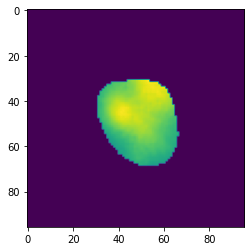

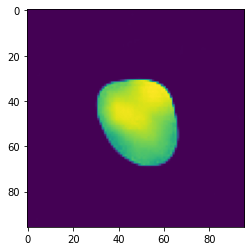

1


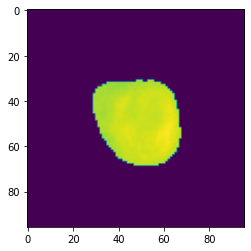

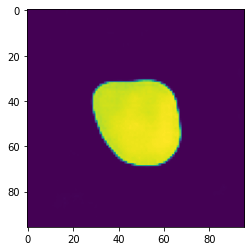

2


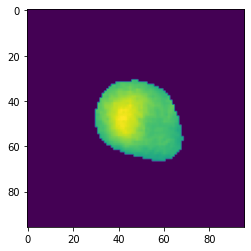

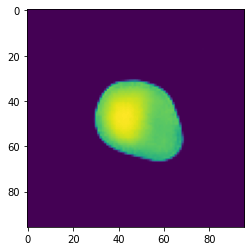

3


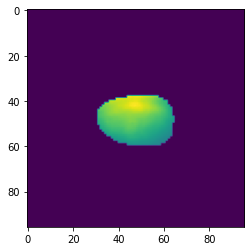

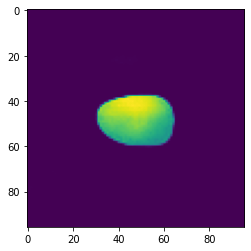

4


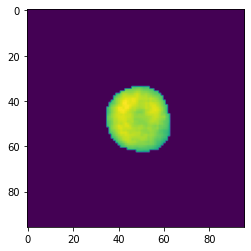

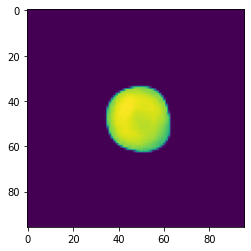

5


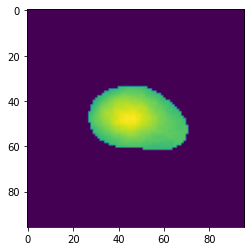

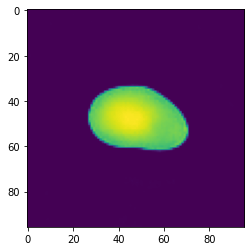

6


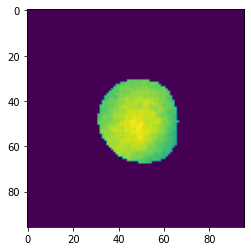

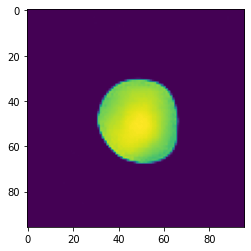

7


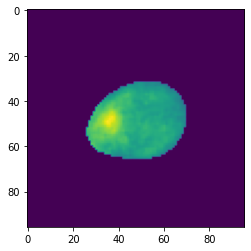

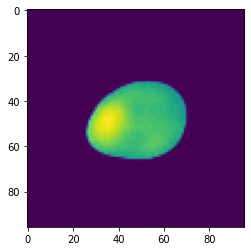

8


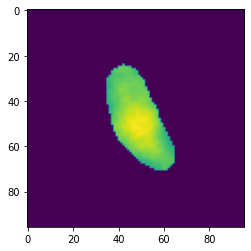

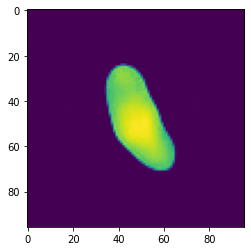

9


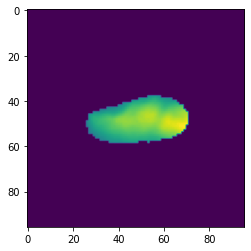

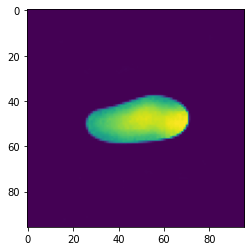

In [12]:
for i in range(10):
    print(i)
    plt.imshow(testInput[i][0].cpu().detach().numpy())
    plt.show()
    plt.imshow(recon[i][0].cpu().detach().numpy())
    plt.show()

In [13]:
#compute latent
ep=311
use_cuda=True
modelcnn.load_state_dict(torch.load(os.path.join(modelsavepath,str(ep)+'.pt')))
latent=np.zeros((allImg.shape[0],fc_dim2))
with torch.no_grad():
    modelcnn.cuda()
    modelcnn.eval()
    nplotBatches=int(np.ceil(allImg.shape[0]/batchsize))
    for i in range(nplotBatches):
        plotInput=torch.tensor(allImg[i*batchsize:min((i+1)*batchsize,allImg.shape[0])])
        if use_cuda:
            plotInput=plotInput.cuda().float()
        recon,z, mu, logvar = modelcnn(plotInput)
        latent[i*batchsize:min((i+1)*batchsize,allImg.shape[0])]=mu.cpu().detach().numpy()


In [14]:
np.random.seed(seed)
def plotembeddingbyCT(ctlist,savename,excludelist,embedding,savepath,plotname,plotdimx=0,plotdimy=1,savenameAdd='',img=None,ncolors=None):
    
    celltypes=np.unique(ctlist)
    if ncolors is None:
        colortest=sns.color_palette("husl", celltypes.size)
    else:
        colortest=sns.color_palette("husl", ncolors)
    fig, ax = plt.subplots(dpi=400)
    if not img is None:
        plt.imshow(img)
    for ct in celltypes:
        if ct in excludelist:
            continue
        idx=(ctlist==ct)
        if not img is None:
            ax.scatter(
                embedding[idx, plotdimy],
                embedding[idx, plotdimx],
#                 color=colortest[celltypes_dict[ct]],label=ct,s=1.5,alpha=0.5
                color=colortest[int(ct)],label=ct,s=1.5,alpha=0.5
                )
        else:
            ax.scatter(
                embedding[idx, plotdimx],
                embedding[idx, plotdimy],
#                 color=colortest[celltypes_dict[ct]],label=ct,s=1.5,alpha=0.5
                color=colortest[int(ct)],label=ct,s=2.5,alpha=1
                )

    plt.gca().set_aspect('equal', 'datalim')
    fig.set_figheight(5)
    fig.set_figwidth(5)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1,
                     box.width, box.height * 0.9])
    # Put a legend below current axis
#     ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
#               fancybox=True, shadow=True, ncol=2,prop={'size': 6})
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
              fancybox=True,ncol=5, shadow=True,prop={'size': 6})
#     ax.legend(ncol=3)
    plt.title(plotname+' embedding', fontsize=12)
    plt.savefig(os.path.join(savepath,savename+savenameAdd+'.jpg'))
#     plt.show()
    
#     fig.clf()
    plt.close('all')
    
    gc.collect()
    
def plotembeddingbyCT_str(ctlist,savename,excludelist,embedding,savepath,plotname,plotdimx=0,plotdimy=1,savenameAdd=''):
    celltypes=np.unique(ctlist)
    celltypes_dict={}
    idx=0
    for ct in celltypes:
        celltypes_dict[ct]=idx
        idx+=1
        
    colortest=sns.color_palette("husl", celltypes.size)
#     colortest=sns.color_palette("husl", 4)
#     np.random.shuffle(colortest)
    fig, ax = plt.subplots(dpi=400)
    for ct in celltypes:
        if ct in excludelist:
            continue
        idx=(ctlist==ct)
        ax.scatter(
            embedding[idx, plotdimx],
            embedding[idx, plotdimy],
            color=colortest[celltypes_dict[ct]],label=ct,s=1.5,alpha=0.5
#             color=colortest[int(ct)],label=ct,s=1.5,alpha=0.5
            )

    plt.gca().set_aspect('equal', 'datalim')
    fig.set_figheight(5)
    fig.set_figwidth(5)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1,
                     box.width, box.height * 0.9])
    # Put a legend below current axis
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
              fancybox=True,ncol=2, shadow=True,prop={'size': 6})
#     ax.legend(ncol=3)
    plt.title(plotname+' embedding', fontsize=24)
#     plt.tight_layout()
    plt.savefig(os.path.join(savepath,savename+savenameAdd+'.jpg'))
#     plt.show()
    
#     fig.clf()
    plt.close('all')
    
    gc.collect()
    
np.random.seed(seed)
def plotembeddingbyCT_contrast(ctlist,savename,excludelist,embedding,savepath,plotname,plotdimx=0,plotdimy=1,savenameAdd='',maxplot=None): 
    celltypes=np.unique(ctlist)
    celltypes_dict={}
    idx=0
    for ct in celltypes:
        celltypes_dict[ct]=idx
        idx+=1

    colortest=sns.color_palette("tab10")
    if not os.path.exists(os.path.join(savepath)):
        os.makedirs(savepath)

    for ct in celltypes:
        if maxplot and int(ct)>maxplot:
            continue
        fig, ax = plt.subplots()
        if ct == 'Unassigned':
            continue

        idx=(ctlist!=ct)
        ax.scatter(
            embedding[idx, plotdimx],
            embedding[idx, plotdimy],
            color=colortest[1],label='others',s=1,alpha=0.5
            )

        idx=(ctlist==ct)
        ax.scatter(
            embedding[idx, plotdimx],
            embedding[idx, plotdimy],
            color=colortest[0],label=ct,s=3,alpha=0.5
            )

        plt.gca().set_aspect('equal', 'datalim')
        fig.set_figheight(10)
        fig.set_figwidth(10)
        ax.legend()
#         plt.title(plotname+' embedding', fontsize=24)
        plt.gcf().savefig(os.path.join(savepath,savename+'_'+str(ct)+savenameAdd+'.jpg'))
#         plt.show()
#         nplot+=1
        
    
#         fig.clf()
        plt.close('all')
        gc.collect()

In [17]:
with open(os.path.join(datadir,'processed','train_cnnvae_names'), 'rb') as input:
    allImgNames=pickle.load(input)
    
n_neighbors=10
min_dist=0.25

savenameAdd='_nn'+str(n_neighbors)+'mdist0'+str(int(min_dist*100))+'epoch'+str(ep)

plottype='umap'
sampledir=plotsavepath
savedir=os.path.join(sampledir,'embedding_'+plottype)
clustersavedir=os.path.join(sampledir,'cluster')
if not os.path.exists(sampledir):
    os.mkdir(sampledir)
if not os.path.exists(savedir):
    os.mkdir(savedir)
if not os.path.exists(clustersavedir):
    os.mkdir(clustersavedir)
    
#plot by disease progression
br1003aSpecs=pd.read_excel('/media/xinyi/dcis2idc1/data/BR1003a specs.xlsx',header=10)
br301Specs=pd.read_excel('/media/xinyi/dcis2idc1/data/BR301 specs.xlsx',header=10)
br8018aSpecs=pd.read_excel('/media/xinyi/dcis2idc1/data/BR8018a specs.xlsx',header=10)
br1003aSpecs.index=br1003aSpecs.loc[:,'Position']
br301Specs.index=br301Specs.loc[:,'Position']
br8018aSpecs.index=br8018aSpecs.loc[:,'Position']

progList=np.copy(allImgNames)
for s in np.unique(allImgNames):
    ssplit=s.split('_')
    if 'br1003a'==ssplit[0]:
        prog_s=br1003aSpecs.loc[(ssplit[-1],'Pathology diagnosis')]
    elif 'br301'==ssplit[0]:
        prog_s=br301Specs.loc[(ssplit[-1],'Pathology diagnosis')]
    elif 'br8018a'==ssplit[0]:
        prog_s=br8018aSpecs.loc[(ssplit[-1],'Pathology diagnosis')]
    progList[allImgNames==s]=prog_s
    


In [18]:
plotepoch=str(ep)
def clusterMinibatchKmean_single(inArray,ncluster,n_pcs,batchsize=400):
    n_pcs=np.min([inArray.shape[0]-1,inArray.shape[1]-1,n_pcs])
    batchsize=int(np.min([(inArray.shape[0]-1)/3,(inArray.shape[1]-1)/3,batchsize]))
    
    kmeansestimator= MiniBatchKMeans(n_clusters=ncluster,random_state=seed,batch_size=batchsize).fit(inArray[:,:n_pcs])
    return kmeansestimator

def clusterMinibatchKmean_allsample(savedir,clustersavedir,inArray,nclusterL,n_pcs,sobj_coord_np,samplenameList,savenameAdd='',plotOnly=False,plotUpdate=True,clusterOnly=False,embeddingSub=None):
    if not plotOnly:
        pca=PCA(copy=True) 
        pca=pca.fit(inArray)
        inArray=pca.transform(inArray)
        savenamepca='pca_epoch'+str(plotepoch)+savenameAdd
        with open(os.path.join(clustersavedir,savenamepca), 'wb') as output:
            pickle.dump(pca, output, pickle.HIGHEST_PROTOCOL)
    
    inertiaList=np.zeros(len(nclusterL))
    for nclusterIdx in range(len(nclusterL)):
        ncluster=nclusterL[nclusterIdx]
        gc.collect()
        print(ncluster)
        savenamecluster='minibatchkmean_ncluster'+str(ncluster)+'n_pcs'+str(n_pcs)+'epoch'+str(plotepoch)+savenameAdd
        if plotOnly and os.path.exists(os.path.join(clustersavedir,savenamecluster)):
            with open(os.path.join(clustersavedir,savenamecluster), 'rb') as output:
                clusterRes=pickle.load(output)
        else:
            kmeansestimator=clusterMinibatchKmean_single(inArray,ncluster,n_pcs)
            clusterRes=kmeansestimator.labels_
            savenamecluster='minibatchkmean_ncluster'+str(ncluster)+'n_pcs'+str(n_pcs)+'epoch'+str(plotepoch)+savenameAdd
            with open(os.path.join(clustersavedir,savenamecluster), 'wb') as output:
                pickle.dump(kmeansestimator.labels_, output, pickle.HIGHEST_PROTOCOL)
            with open(os.path.join(clustersavedir,savenamecluster+'_estimator'), 'wb') as output:
                pickle.dump(kmeansestimator, output, pickle.HIGHEST_PROTOCOL)
            if embeddingSub is None:
                plotembeddingbyCT(clusterRes,'minibatchkmean',[],embedding,savedir,plottype+' of all samples',savenameAdd=savenamecluster)
                plotembeddingbyCT_contrast(clusterRes,'minibatchkmean',[],embedding,os.path.join(savedir,'contrast'),plottype+' of all samples',savenameAdd=savenamecluster,maxplot=50)
            else:
                plotembeddingbyCT(clusterRes,'minibatchkmean',[],embeddingSub,savedir,plottype+' of all samples',savenameAdd=savenamecluster)
                plotembeddingbyCT_contrast(clusterRes,'minibatchkmean',[],embeddingSub,os.path.join(savedir,'contrast'),plottype+' of all samples',savenameAdd=savenamecluster,maxplot=50)

        
        if not plotOnly:
            inertiaList[nclusterIdx]=kmeansestimator.inertia_
            
    if not plotOnly:
        plt.plot(nclusterL, inertiaList, 'bx-')
        plt.xlabel('Values of K')
        plt.ylabel('Inertia')
        plt.savefig(os.path.join(savedir,'minibatchkmean'+savenamecluster+'_elbow.jpg'))
        plt.close()
         

In [19]:
progNames,progCounts=np.unique(progList,return_counts=True)
progSampleRate={}
for p in range(progNames.size):
    progSampleRate[progNames[p]]=np.min(progCounts)/progCounts[p]

In [30]:
np.random.seed(6)
# plotPCT=4500
plottingIdx_i=np.array([])
n_pcs=50
uniqueImgNames,imgNameIdx=np.unique(allImgNames,return_index=True)
for i in range(1):
    for sidx in range(uniqueImgNames.size):
        s=uniqueImgNames[sidx]
        p=progList[imgNameIdx[sidx]]
        print(s+' '+p)
        nsamples=int(np.sum(allImgNames==s)*progSampleRate[p])
        plottingIdx_i=np.concatenate((plottingIdx_i,
                                    np.random.choice(np.arange(allImgNames.shape[0])[allImgNames==s],nsamples,replace=False)))
    
    np.random.seed(6)
    n_neighbors=10
    min_dist=0.25
    reducer = umap.UMAP(n_neighbors=n_neighbors,min_dist=min_dist,random_state=seed).fit(latent[plottingIdx_i.astype(int)])
    savenameAdd='_nn'+str(n_neighbors)+'mdist0'+str(int(min_dist*100))+'epoch'+str(ep)

    with open(os.path.join(modelsavepath,'umap_plottingIdx_progBalanced_'+str(i)+savenameAdd), 'wb') as output:
        pickle.dump(reducer, output, pickle.HIGHEST_PROTOCOL)
        
    embedding=reducer.embedding_    
    clusterMinibatchKmean_allsample(savedir,clustersavedir,latent[plottingIdx_i.astype(int)],[8],n_pcs,None,allImgNames[plottingIdx_i.astype(int)],'_plottingIdx_progBalanced_'+str(i))
    gc.collect()

8


0

In [43]:
def plotCTcomp_hist(labels,ctlist,savepath,savenamecluster,byCT,addname=''):
    res=np.zeros((np.unique(labels).size,np.unique(ctlist).size))
    for li in range(res.shape[0]):
        l=np.unique(labels)[li]
        nl=np.sum(labels==l)
        ctlist_l=ctlist[labels==l]
        for ci in range(res.shape[1]):
            c=np.unique(ctlist)[ci]
            res[li,ci]=np.sum(ctlist_l==c)
#             res[li,ci]=np.sum(ctlist_l==c)/nl
    if not byCT:
        addname+=''
        for li in range(res.shape[0]):
            l=np.unique(labels)[li]
            nl=np.sum(labels==l)
            res[li]=res[li]/nl
    else:
        addname+='_normbyCT'
        for ci in range(res.shape[1]):
            c=np.unique(ctlist)[ci]
            nc=np.sum(ctlist==c)
            res[:,ci]=res[:,ci]/nc
    
    fig, ax = plt.subplots(nrows=res.shape[0], ncols=1,figsize=(10, 10),sharex=True,sharey=True)
    for r in range(res.shape[0]):
        ax[r].bar(np.arange(res.shape[1]),res[r])
        ax[r].set_xticks(np.arange(np.unique(ctlist).size))
        ax[r].set_xticklabels(np.unique(ctlist))
        ax[r].set_ylim(0,1)
        ax[r].set_ylabel(np.unique(labels)[r])
        
#         ax.set_yticks(np.arange(np.unique(labels).size))
#         ax.set_yticklabels(np.unique(labels))
#         ax.set_xticks(np.arange(np.unique(ctlist).size))
#         ax.set_xticklabels(np.unique(ctlist))
#         plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
    fig.tight_layout()
    plt.savefig(os.path.join(savepath,savenamecluster+addname+'.jpg'))
    plt.close()

In [38]:
plotsavenameAdd='_plottingIdx_progBalanced_'+str(i)

In [41]:
import util.plot_new

In [ ]:
progList_comb=np.copy(progList)
for p in np.unique(progList):
    if p=='Ductal carcinoma in situ':
        progList_comb[progList==p]='DCIS and breast tissue'
        progList[progList==p]='DCIS'
    elif p=='Ductal carcinoma in situ and breast tissue':
        progList_comb[progList==p]='DCIS and breast tissue'
        progList[progList==p]='DCIS and breast tissue'
    elif p=='Ductal carcinoma in situ with early infiltratio':
        progList_comb[progList==p]='DCIS with early infiltration'
        progList[progList==p]='DCIS with early infiltration'
    elif p=='Micropapillary type ductal carcinoma in situ wi':
        progList_comb[progList==p]='DCIS with early infiltration'
        progList[progList==p]='Micropapillary DCIS with early infiltration'
    elif p=='Atypical hyperlasia':
        progList_comb[progList==p]='Hyperplasia'

In [46]:
ctorder=np.array(['Breast tissue','Cancer adjacent normal breast tissue','Invasive ductal carcinoma (breast tissue)','Hyperplasia','Atypical hyperplasia','DCIS and breast tissue','DCIS','DCIS with early infiltration', 'Micropapillary DCIS with early infiltration','Invasive ductal carcinoma and breast tissue','Invasive ductal carcinoma'])
nclusterL=[8]
for ncluster in nclusterL:
    savenamecluster='minibatchkmean_ncluster'+str(ncluster)+'n_pcs'+str(n_pcs)+'epoch'+str(plotepoch)+plotsavenameAdd
    with open(os.path.join(clustersavedir,savenamecluster), 'rb') as output:
        clusterRes=pickle.load(output)
    clusterplotsavepath=os.path.join(clustersavedir,savenamecluster+'_plots')
    if not os.path.exists(clusterplotsavepath):
        os.mkdir(clusterplotsavepath)
    util.plot_new.plotCTcomp(clusterRes,progList[plottingIdx_i.astype(int)],clusterplotsavepath,'pathologyHeatmap_rename',False,ctorder=ctorder,vmin=0)
    util.plot_new.plotCTcomp(clusterRes,progList[plottingIdx_i.astype(int)],clusterplotsavepath,'pathologyHeatmap_rename',True,ctorder=ctorder,vmin=0)

In [47]:
neworder=[3,2,6,0,4,7,5,1]
clusterRes_reordered=np.zeros_like(clusterRes)
for c in range(ncluster):
    cold=neworder[c]
    clusterRes_reordered[clusterRes==cold]=c


In [49]:
for ncluster in nclusterL:
    savenamecluster='minibatchkmean_ncluster'+str(ncluster)+'n_pcs'+str(n_pcs)+'epoch'+str(plotepoch)+plotsavenameAdd
    clusterplotsavepath=os.path.join(clustersavedir,savenamecluster+'_plots')
    util.plot_new.plotCTcomp(clusterRes_reordered,progList[plottingIdx_i.astype(int)],clusterplotsavepath,'pathologyHeatmap_rename_reordered',False,ctorder=ctorder,vmin=0)
    util.plot_new.plotCTcomp(clusterRes_reordered,progList[plottingIdx_i.astype(int)],clusterplotsavepath,'pathologyHeatmap_rename_reordered',True,ctorder=ctorder,vmin=0)

In [53]:
refDir=os.path.join('/media/xinyi/dcis2idc1/plots/cnnvaeexp0','cluster')
savenamecluster='minibatchkmean_ncluster'+str(ncluster)+'n_pcs'+str(n_pcs)+'epoch'+str(plotepoch)+'_plottingIdx_progBalanced_'+str(i)+'_reordered'
with open(os.path.join(refDir,savenamecluster), 'rb') as output:
    clusterRes_ref=pickle.load(output)

In [55]:
util.plot_new.plotCTcomp(clusterRes_reordered,clusterRes_ref,clusterplotsavepath,'compareToOriginal',False,vmin=0)


In [58]:
testIdx_i[:10]

array([ 946042,  268296, 1680734,  610892, 1732454,   41777,  820490,
        145414, 1635248,  697208])